## Problem Statement

Develop and summarize a model to classify solution words by difficulty. Identify the attributes of a given word that are associated with each classification. Using your model, how difficult is the word EERIE? Discuss the accuracy of your classification model.

In [326]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [327]:
import warnings
warnings.filterwarnings("ignore")

In [328]:
totWords = 2309
charRank = {'a': 906, 'b': 266, 'c': 446, 'd': 370, 'e': 1053, 'f': 206, 'g': 299, 'h': 377, 'i': 646, \
            'j': 27, 'k': 202, 'l': 645, 'm': 298, 'n': 548, 'o': 672, 'p': 345, 'q': 29, 'r': 835, \
            's': 617, 't': 667, 'u': 456, 'v': 148, 'w': 193, 'x': 37, 'y': 416, 'z': 35}
charRankByPos = [{'a': 140, 'b': 173, 'c': 198, 'd': 111, 'e': 72, 'f': 135, 'g': 115, 'h': 69, \
                  'i': 34, 'j': 20, 'k': 20, 'l': 87, 'm': 107, 'n': 37, 'o': 41, 'p': 141, 'q': 23, \
                  'r': 105, 's': 365, 't': 149, 'u': 33, 'v': 43, 'w': 82, 'y': 6, 'z': 3}, \
                 {'a': 304, 'b': 16, 'c': 40, 'd': 20, 'e': 241, 'f': 8, 'g': 11, 'h': 144, 'i': 201, 'j': 2, \
                  'k': 10, 'l': 200, 'm': 38, 'n': 87, 'o': 279, 'p': 61, 'q': 5, 'r': 267, 's': 16, 't': 77, \
                  'u': 185, 'v': 15, 'w': 44, 'x': 14, 'y': 22, 'z': 2}, {'a': 306, 'b': 56, 'c': 56, 'd': 75, \
                  'e': 177, 'f': 25, 'g': 67, 'h': 9, 'i': 266, 'j': 3, 'k': 12, 'l': 112, 'm': 61, 'n': 137, 'o': 243, \
                  'p': 57, 'q': 1, 'r': 163, 's': 80, 't': 111, 'u': 165, 'v': 49, 'w': 26, 'x': 12, 'y': 29, 'z': 11}, \
                 {'a': 162, 'b': 24, 'c': 150, 'd': 69, 'e': 318, 'f': 35, 'g': 76, 'h': 28, 'i': 158, 'j': 2, \
                  'k': 55, 'l': 162, 'm': 68, 'n': 182, 'o': 132, 'p': 50, 'r': 150, 's': 171, 't': 139, 'u': 82, \
                  'v': 45, 'w': 25, 'x': 3, 'y': 3, 'z': 20}, {'a': 63, 'b': 11, 'c': 31, 'd': 118, 'e': 422, 'f': 26, \
                  'g': 41, 'h': 137, 'i': 11, 'k': 113, 'l': 155, 'm': 42, 'n': 130, 'o': 58, 'p': 56, 'r': 212, 's': 36, \
                  't': 253, 'u': 1, 'w': 17, 'x': 8, 'y': 364, 'z': 4}]

def charCount(s):
    dic = {}
    for ch in s:
        try:
            dic[ch] += 1
        except KeyError:
            dic[ch] = 1
    return dic

def calc_roc(s): 
    dic = charCount(s)
    l = [val for val in dic.values()]
    return stats.entropy(l)

def calc_pov(s):
    I2 = 0
    for c in s:
        if c in ["a", "e", "i", "o", "u"]: I2 += 1
    return I2 / 5

def calc_rank():
    with open("./dataset/wordle_wordbank.txt") as f:
        lines = f.readlines()
    print(len(lines))
    lines = [s.strip() for s in lines]
    dic = {}
    dic2 = [{} for _ in range(5)]
    for s in lines:
        for c in set(s.lower()):
            try: dic[c] += 1
            except KeyError: dic[c] = 1
        for i, c in enumerate(s):
            try: dic2[i][c] += 1
            except KeyError: dic2[i][c] = 1
    return dict(sorted(dic.items())), [dict(sorted(dic2[i].items())) for i in range(5)]

def calc_EYH(s):
    I3 = 0
    for c in set(s):
        I3 += charRank[c] / totWords
    return I3

# I3G is expectation of green hits
def calc_EGH(s):
    I3 = 0
    for i, c in enumerate(s):
        I3 += charRankByPos[i][c] / totWords
    return I3

First, read the dates and the corresponding data and preprocess data as previously did.

In [329]:
df = pd.read_excel("./dataset/wordle_data.xlsx", index_col=0, usecols="A,C,F:L")
df = df.sort_index()
df_chars = pd.DataFrame(index=df.index, data=[[ord(c) - 97 for c in ch] for ch in df["word"].apply(func=list).values], columns=["ch1", "ch2", "ch3", "ch4", "ch5"])
df[df_chars.columns] = df_chars
df["ROC"] = [calc_roc(word) for word in df["word"]]
df["EYH"] = [calc_EYH(word) for word in df["word"]]
df["EGH"] = [calc_EGH(word) for word in df["word"]]
del df["word"]

Standardize features by removing the mean and scaling to unit variance.

In [330]:
scalar = StandardScaler()
df_scaled = scalar.fit_transform(df)

Use PCA for dimension reduction and pick the first two principal components.

In [331]:
pca = PCA(n_components=2, random_state=1)
df_scaled_pca = pca.fit_transform(df_scaled)
pc0, pc1 = df_scaled_pca[:, 0], df_scaled_pca[:, 1]

Use k-Means for clustering.

In [332]:
kmeans = KMeans(n_clusters=6, n_init="auto", random_state=1)
kmeans.fit(df_scaled)
df_scaled_kmeans = kmeans.fit_predict(df_scaled)
print("Sihoutte score: {:.4e}".format(silhouette_score(df_scaled, df_scaled_kmeans)))

Sihoutte score: 9.5019e-02


Visualize the clustering result based on the two principal components.

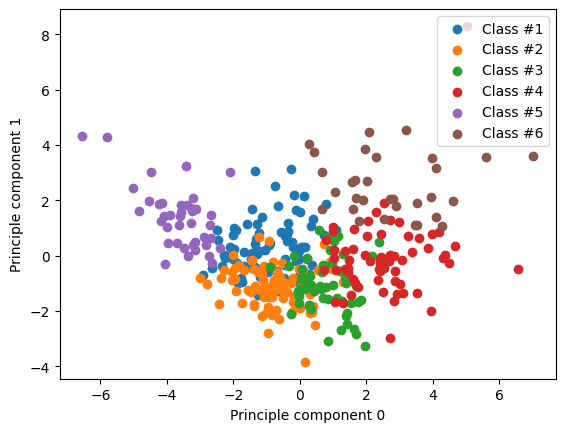

In [333]:
labels = ["Class #1", "Class #2", "Class #3", "Class #4", "Class #5", "Class #6"]
for clusnum in np.unique(df_scaled_kmeans):
    idx = df_scaled_kmeans == clusnum
    plt.scatter(pc0[idx], pc1[idx], label=labels[clusnum])
plt.xlabel("Principle component 0")
plt.ylabel("Principle component 1")
plt.legend()
plt.show()

Reorganize data so as to determine the difficulty level of each class.

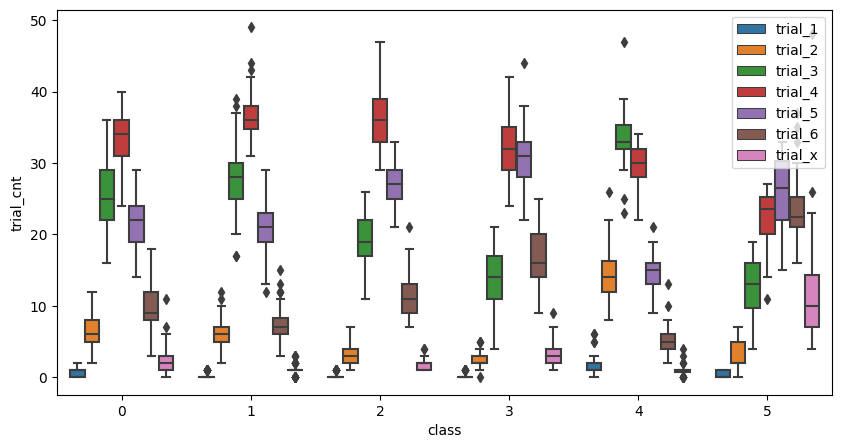

In [334]:
df_kmeans = df[["trial_1", "trial_2", "trial_3", "trial_4", "trial_5", "trial_6", "trial_x"]]
df_kmeans["class"] = df_scaled_kmeans
df_kmeans = df_kmeans.melt(value_vars=["trial_1", "trial_2", "trial_3", "trial_4", "trial_5", "trial_6", "trial_x"], var_name="trials", value_name="trial_cnt", id_vars=["class"])
plt.figure(figsize=(10, 5))
sns.boxplot(data=df_kmeans, x="class", y="trial_cnt", hue="trials")
plt.legend(loc="upper right")
plt.show()

In [351]:
df_class = df_kmeans.groupby("class").mean().sort_values(by="trial_cnt")
df_class["difficulty"] = ["easy", "easy", "medium", "medium", "hard", "hard"]
print(df_class)

       trial_cnt difficulty
class                      
2      14.248244       easy
1      14.255357       easy
3      14.269321     medium
5      14.281250     medium
0      14.282353       hard
4      14.314286       hard


Predict for the word EERIE.

In [354]:
eerie_attrs = {"trial_1": 0, "trial_2": 4, "trial_3": 18, "trial_4": 32, "trial_5": 27, "trial_6": 15, "trial_x": 4, \
               "ch1": ord("e") - 97, "ch2": ord("e") - 97, "ch3": ord("r") - 97, "ch4": ord("i") - 97, "ch5": ord("e") - 97, \
               "ROC": calc_roc("eerie"), "EYH": calc_EYH("eerie"), "EGH": calc_EGH("eerie")}
X_pred = pd.DataFrame(index=[pd.to_datetime("2023/03/01", format="%Y-%m-%d")], data=eerie_attrs)
X_pred_scaled = scalar.transform(X_pred)
class_pred = kmeans.predict(X_pred_scaled)
print("EERIE belongs to Class #{}, of {} level difficulty".format(class_pred[0], df_class.loc[class_pred[0], "difficulty"]))

EERIE belongs to Class #3, of medium level difficulty
